In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as album

# Pytorch에서 gpu를 사용하는 방법.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print('Current cuda device ', torch.cuda.current_device())

Current cuda device  0


In [9]:
from segmentation_models_master import segmentation_models_pytorch as smp

In [11]:
df_test = pd.read_csv('./test.csv')

In [12]:
train_img_dir = './pro_data/data_for_training_and_testing/train/images/'
train_mask_dir = './pro_data/data_for_training_and_testing/train/masks/'

valid_img_dir = './pro_data/data_for_training_and_testing/val/images/'
valid_mask_dir = './pro_data/data_for_training_and_testing/val/masks/'

In [13]:
data_train_img = sorted(os.listdir(train_img_dir))
data_train_mask = sorted(os.listdir(train_mask_dir))

data_val_img = sorted(os.listdir(valid_img_dir))
data_val_mask = sorted(os.listdir(valid_mask_dir))

In [14]:
df_train = pd.DataFrame({'img_path': data_train_img, 'mask_path': data_train_mask})
df_valid = pd.DataFrame({'img_path': data_val_img, 'mask_path': data_val_mask})

In [15]:
class_dict = pd.read_csv("./label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [16]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [17]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [18]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [19]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, chk=0, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        #for i in range(len(self.data.iloc[:,1] )):
          #self.data.iloc[:,1][i]=self.data.iloc[:,1][i].replace("./", "/")
        #self.data.iloc[:,1] = "./data/" + self.data.iloc[:,1]
        self.transform = transform
        self.infer = infer
        self.chk = chk
        class_rgb_values=None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
                #image = torch.tensor(image, dtype=torch.float32) / 255.0
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            #image = torch.tensor(image, dtype=torch.float32) / 255.0
        if(self.chk==0):
          return image, mask
        elif (self.chk==1):
          image = image[:,:224,:224]
          mask = mask[:224, :224]
          return image, mask
        elif (self.chk==2):
          image = image[:,:224,224:448]
          mask = mask[:224, 224:448]
          return image, mask
        elif (self.chk==3):
          image = image[:,:224,448:672]
          mask = mask[:224, 448:672]
          return image, mask
        elif (self.chk==4):
          image = image[:,:224,672:]
          mask = mask[:224, 672:]
          return image, mask
        elif (self.chk==5):
          image = image[:,224:448,:224]
          mask = mask[224:448, :224]
          return image, mask
        elif (self.chk==6):
          image = image[:,224:448,224:448]
          mask = mask[224:448, 224:448]
          return image, mask
        elif (self.chk==7):
          image = image[:,224:448,448:672]
          mask = mask[224:448, 448:672]
          return image, mask
        elif (self.chk==8):
          image = image[:,224:448,672:]
          mask = mask[224:448, 672:]
          return image, mask
        elif (self.chk==9):
          image = image[:,448:672,:224]
          mask = mask[448:672, :224]
          return image, mask
        elif (self.chk==10):
          image = image[:,448:672,224:448]
          mask = mask[448:672, 224:448]
          return image, mask
        elif (self.chk==11):
          image = image[:,448:672,448:672]
          mask = mask[448:672, 448:672]
          return image, mask
        elif (self.chk==12):
          image = image[:,448:672,672:]
          mask = mask[448:672, 672:]
          return image, mask
        elif (self.chk==13):
          image = image[:, 672:,:224]
          mask = mask[672:, :224]
          return image, mask
        elif (self.chk==14):
          image = image[:, 672:,224:448]
          mask = mask[672:, 224:448]
          return image, mask
        elif (self.chk==15):
          image = image[:, 672:,448:672]
          mask = mask[672:, 448:672]
          return image, mask
        else:
          image = image[:, 672:,672:]
          mask = mask[672:, 672:]
          return image, mask

In [20]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = train_img_dir + df_train['img_path']
        self.mask_paths = train_mask_dir + df_train['mask_path']

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

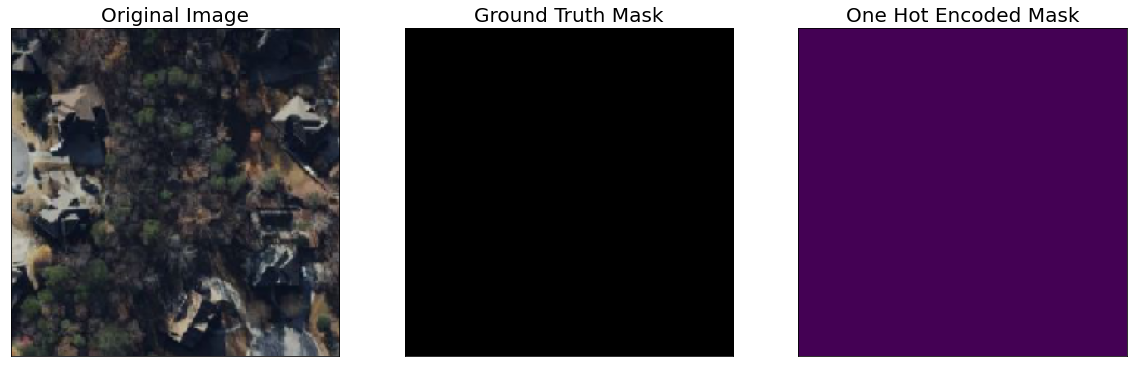

In [21]:
dataset = BuildingsDataset(train_img_dir, train_mask_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [22]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=224, width=224, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

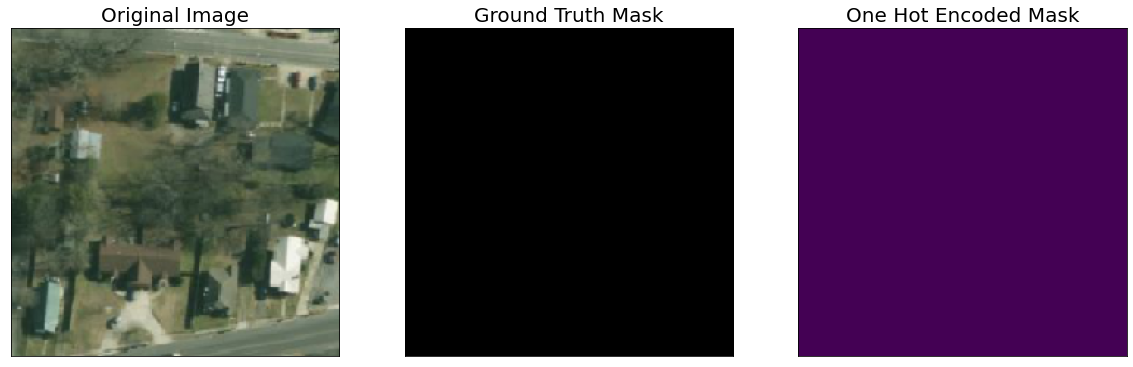

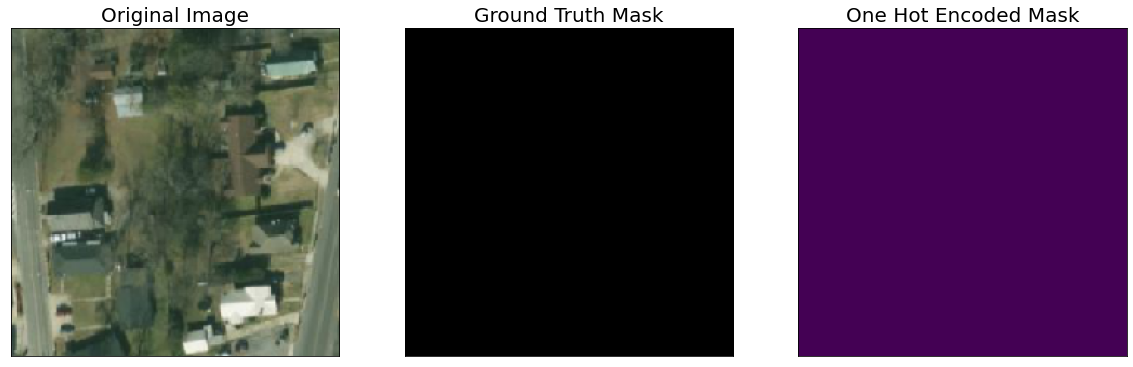

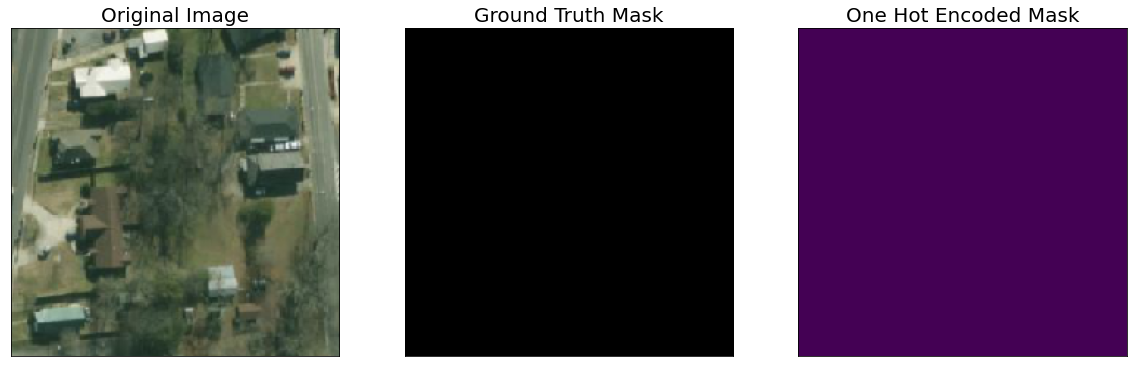

In [23]:
augmented_dataset = BuildingsDataset(
    train_img_dir, train_mask_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [24]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
model = nn.DataParallel(model, device_ids = [1, 2, 3, 4, 5])

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [25]:
train_dataset = BuildingsDataset(
    train_img_dir, train_mask_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    valid_img_dir, valid_mask_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=16)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [26]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 80

loss = smp.losses.DiceLoss('binary')

# lets assume we have multilabel prediction for 3 classes
output = torch.rand([10, 3, 256, 256])
target = torch.rand([10, 3, 256, 256]).round().long()

# first compute statistics for true positives, false positives, false negative and
# true negative "pixels"
tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multilabel', threshold=0.5)

# then compute metrics with required reduction (see metric docs)
iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('./best_model.pth'):
    model = torch.load('./best_model.pth', map_location=DEVICE)

In [28]:
train_epoch = smp.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

AttributeError: module 'segmentation_models_master.segmentation_models_pytorch' has no attribute 'train'

In [9]:
!unzip -uq segmentation_models_pytorch.zip

In [29]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0


NameError: name 'train_epoch' is not defined